In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
import imageio

In [4]:
import lanelines
import roadplane

from compgraph import CompGraph, CompGraphRunner
import nxpd
nxpd.nxpdParams['show'] = 'ipynb'

In [5]:
from newlanespipeline import computational_graph as cg
from newlanespipeline import parameters as cg_params
from roadplane import prepare_perspective_transforms_custom
from smooth import Smoother, Memory, compute_diffs

In [6]:
CANVAS_SZ = (500, 1500)
M, Minv = prepare_perspective_transforms_custom(CANVAS_SZ)

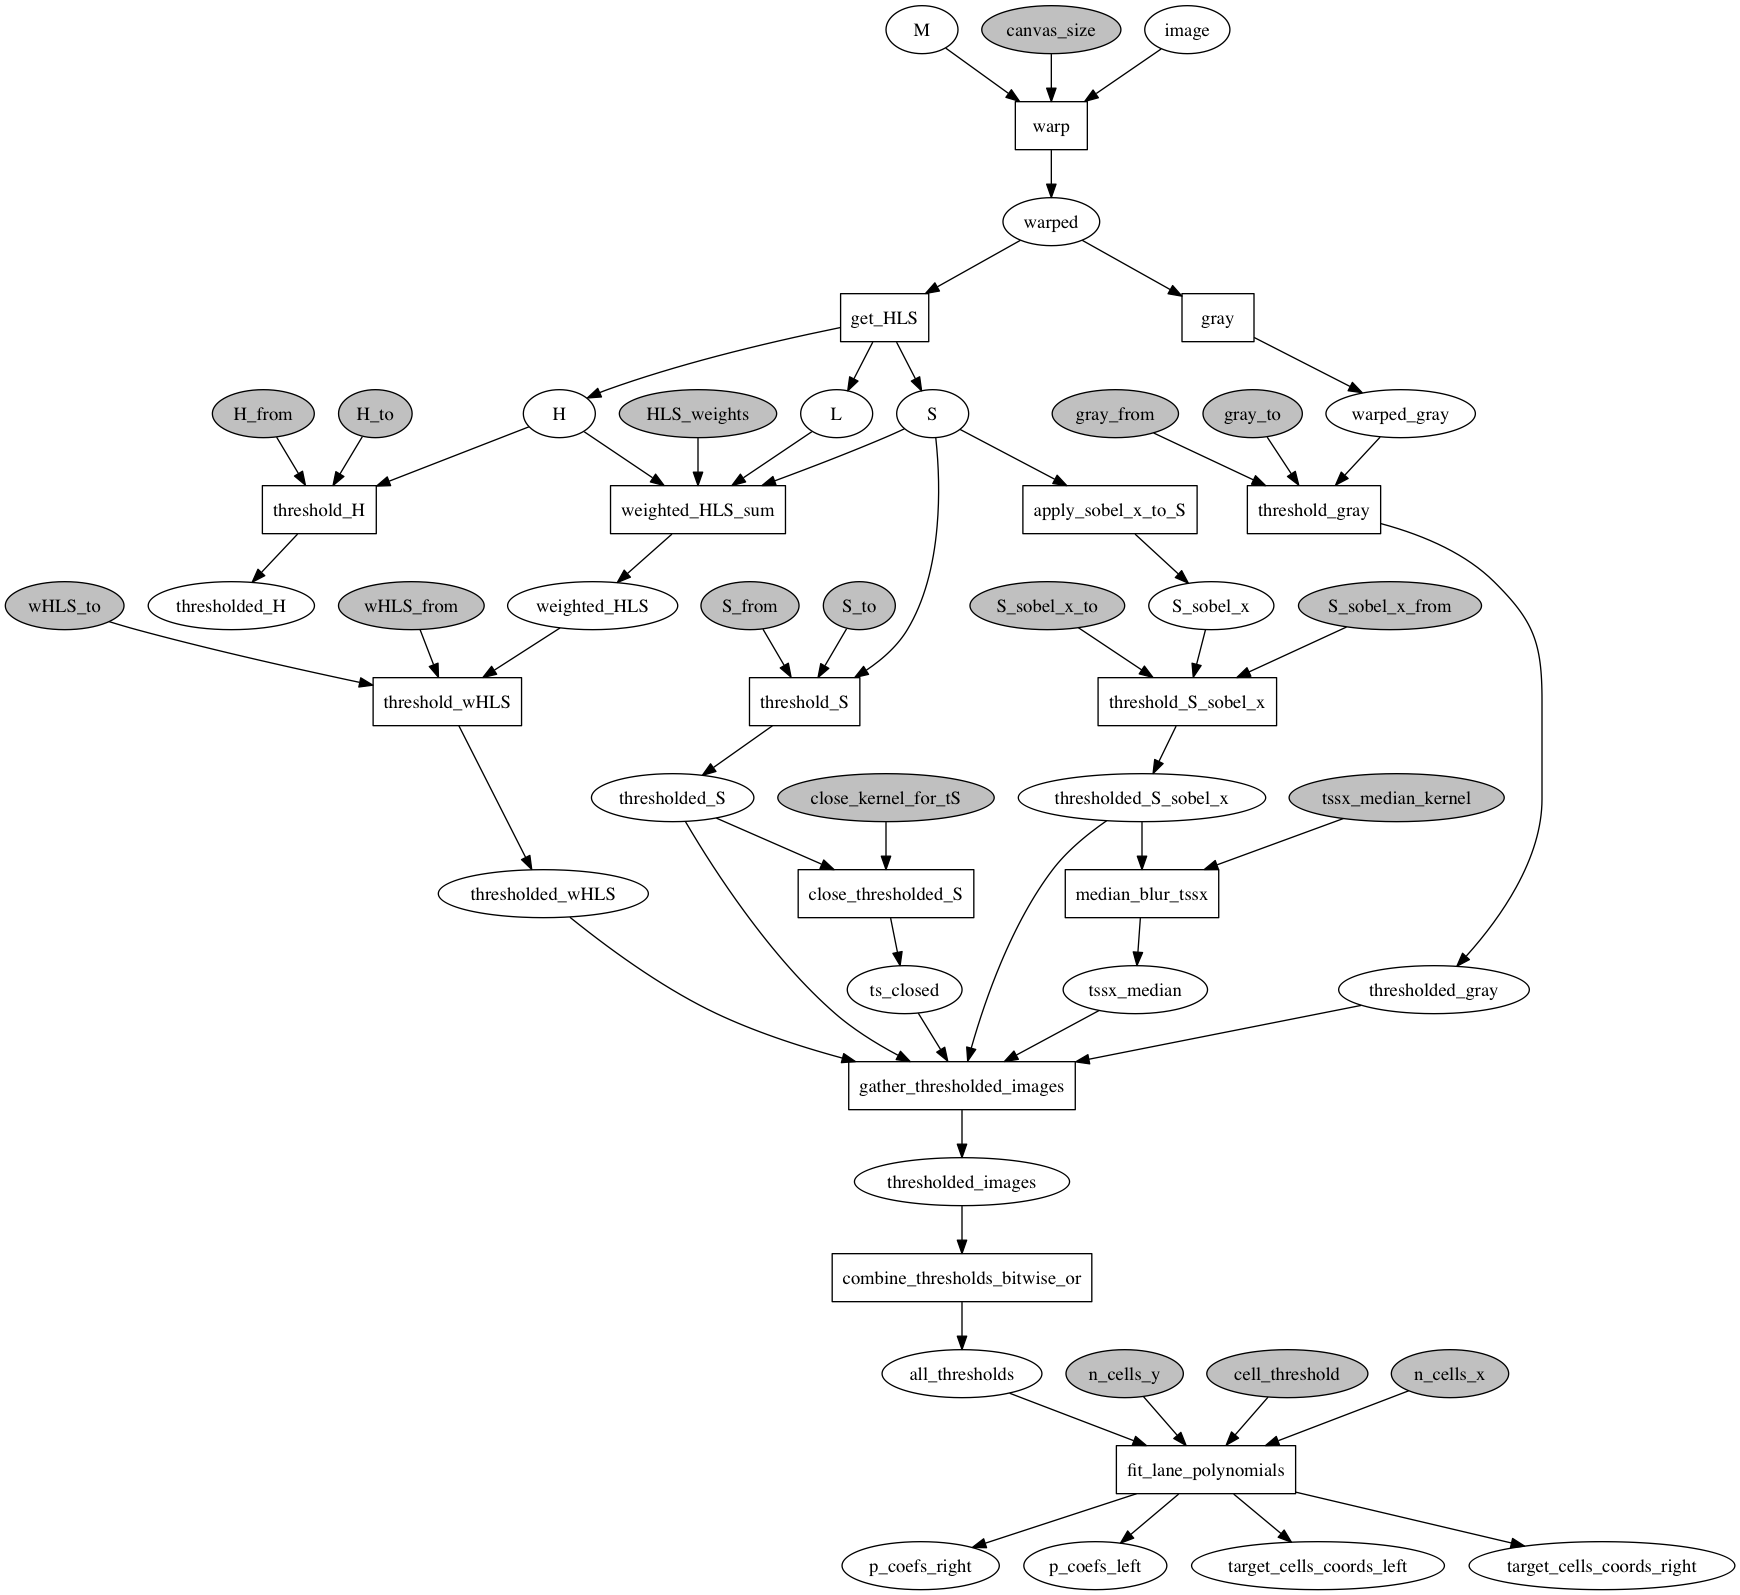

In [7]:
runner = CompGraphRunner(cg, frozen_tokens=cg_params)
nxpd.draw(runner.token_manager.to_networkx())

In [8]:
video_rd = imageio.get_reader('project_video.mp4')

In [9]:
all_p_coefs_left = []
all_p_coefs_right = []
all_curvatures = []

for frame in video_rd:
    
    runner.run(image=frame, M=M)
    
    all_p_coefs_left.append(runner['p_coefs_left'])
    all_p_coefs_right.append(runner['p_coefs_right'])
    
all_p_coefs_left = np.array(all_p_coefs_left)
all_p_coefs_right = np.array(all_p_coefs_right)

In [10]:
all_diffs_left = compute_diffs(all_p_coefs_left)
all_diffs_right = compute_diffs(all_p_coefs_right)

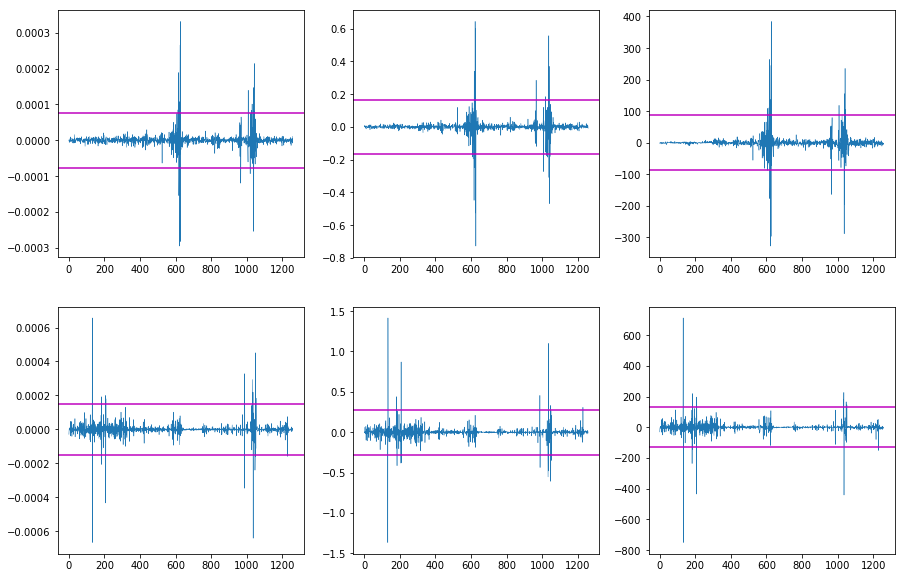

In [11]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(all_diffs_left[:, 0], linewidth=0.5)
plt.axhline(all_diffs_left[:, 0].std() * 3, color='m')
plt.axhline(-all_diffs_left[:, 0].std() * 3, color='m')

plt.subplot(2, 3, 2)
plt.plot(all_diffs_left[:, 1], linewidth=0.5)
plt.axhline(all_diffs_left[:, 1].std() * 3, color='m')
plt.axhline(-all_diffs_left[:, 1].std() * 3, color='m')

plt.subplot(2, 3, 3)
plt.plot(all_diffs_left[:, 2], linewidth=0.5)
plt.axhline(all_diffs_left[:, 2].std() * 3, color='m')
plt.axhline(-all_diffs_left[:, 2].std() * 3, color='m')

plt.subplot(2, 3, 4)
plt.plot(all_diffs_right[:, 0], linewidth=0.5)
plt.axhline(all_diffs_right[:, 0].std() * 3, color='m')
plt.axhline(-all_diffs_right[:, 0].std() * 3, color='m')

plt.subplot(2, 3, 5)
plt.plot(all_diffs_right[:, 1], linewidth=0.5)
plt.axhline(all_diffs_right[:, 1].std() * 3, color='m')
plt.axhline(-all_diffs_right[:, 1].std() * 3, color='m')

plt.subplot(2, 3, 6)
plt.plot(all_diffs_right[:, 2], linewidth=0.5)
plt.axhline(all_diffs_right[:, 2].std() * 3, color='m')
plt.axhline(-all_diffs_right[:, 2].std() * 3, color='m')



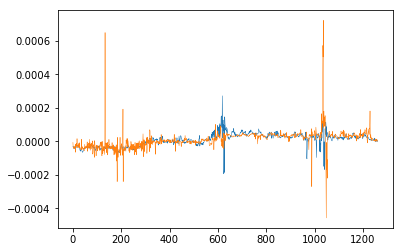

In [12]:
plt.plot(all_p_coefs_left[:, 0], linewidth=0.5)
plt.plot(all_p_coefs_right[:, 0], linewidth=0.5)

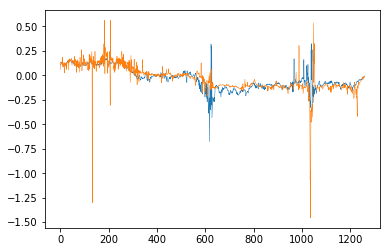

In [13]:
plt.plot(all_p_coefs_left[:, 1], linewidth=0.5)
plt.plot(all_p_coefs_right[:, 1], linewidth=0.5)

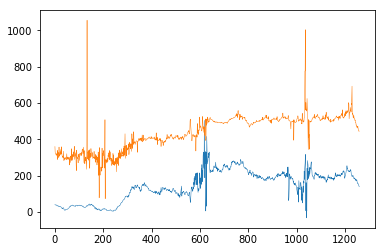

In [14]:
plt.plot(all_p_coefs_left[:, 2], linewidth=0.5)
plt.plot(all_p_coefs_right[:, 2], linewidth=0.5)

In [15]:
dt = {
    'p_coefs_left': np.array([1e-4, 0.15, 90.]),
    'p_coefs_right': np.array([1.8e-4, 0.25, 150.])
}

In [16]:
#N = 100
N = len(video_rd)

smoo = Smoother(runner, M, ['p_coefs_left', 'p_coefs_right'], diff_thresholds=dt)

sm_p_coefs_left = []
sm_p_coefs_right = []

for i, frame in enumerate(video_rd):
    
    if i > N:
        break
    
    res = smoo(frame)
    
    runner.run(image=frame, M=M, Minv=Minv)
    
    sm_p_coefs_left.append(res['p_coefs_left'])
    sm_p_coefs_right.append(res['p_coefs_right'])
    
sm_p_coefs_left = np.array(sm_p_coefs_left)
sm_p_coefs_right = np.array(sm_p_coefs_right)

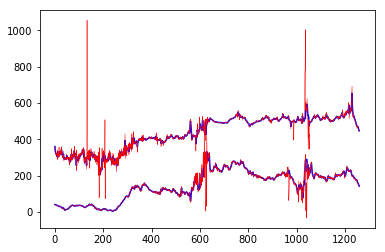

In [17]:
plt.plot(sm_p_coefs_left[:, 2], color='b')
plt.plot(sm_p_coefs_right[:, 2], color='b')

plt.plot(all_p_coefs_left[:N, 2], linewidth=0.5, color='r')
plt.plot(all_p_coefs_right[:N, 2], linewidth=0.5, color='r')

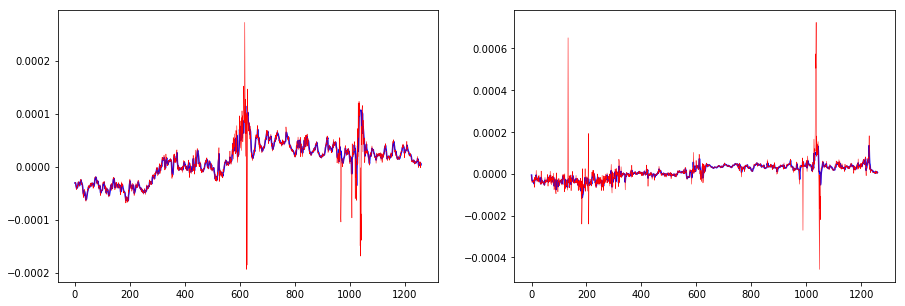

In [18]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(sm_p_coefs_left[:, 0], color='b')
plt.plot(all_p_coefs_left[:N, 0], linewidth=0.5, color='r')

plt.subplot(1, 2, 2)
plt.plot(sm_p_coefs_right[:, 0], color='b')
plt.plot(all_p_coefs_right[:N, 0], linewidth=0.5, color='r')

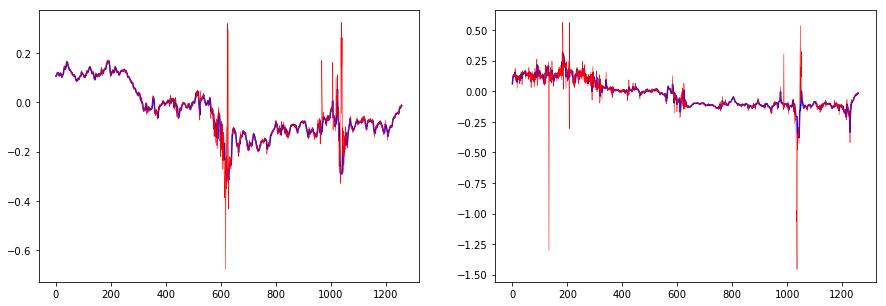

In [19]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(sm_p_coefs_left[:, 1], color='b')
plt.plot(all_p_coefs_left[:N, 1], linewidth=0.5, color='r')

plt.subplot(1, 2, 2)
plt.plot(sm_p_coefs_right[:, 1], color='b')
plt.plot(all_p_coefs_right[:N, 1], linewidth=0.5, color='r')

In [20]:
class OldSmoother(object):
    
    def __init__(self, runner, M, Minv, token_names):
        self._runner = runner
        self._token_names = token_names
        self._M = M
        self._Minv = Minv
        
        self._last = {tk: None for tk in token_names}
        self._diff = {tk: None for tk in token_names}
    
    def __call__(self, im, diff_ratio_threshold=50.):
        
        res = {}
        
        self._runner.run(image=im, M=self._M, Minv=self._Minv)
        
        for tk in self._token_names:            
            val = runner[tk]

            if self._last[tk] is None: # the first point
                #print('first')
                self._last[tk] = val
                res[tk] = val
                continue
                
            smoothed = 0.5 * (val + self._last[tk])
            diff = smoothed - self._last[tk]
            
            
            if self._diff[tk] is not None: # 3rd point and onwards

                diff_ratio = diff / self._diff[tk]
                
                if np.linalg.norm(diff_ratio) > diff_ratio_threshold:
                    #print('anomaly')
                    extrapolated = self._last[tk] + self._diff[tk]
                    self._last[tk] = extrapolated
                    res[tk] = extrapolated
                    continue     
            
                    
            #print('ok')
            self._diff[tk] = diff
            self._last[tk] = smoothed
            res[tk] = smoothed
            
        return res

In [21]:
class SmootherWithMemory(object):
    
    def __init__(self, runner, M, Minv, token_names, memory_size=5):
        self._runner = runner
        self._token_names = token_names
        self._M = M
        self._Minv = Minv
        
        self._mem = {tk: Memory(memory_size) for tk in token_names}
    
    def __call__(self, im):
        
        res = {}
        
        self._runner.run(image=im, M=self._M, Minv=self._Minv)
        
        for tk in self._token_names:            
            
            val = runner[tk]

            if not self._mem[tk].is_full(): 
                self._mem[tk].insert(val)
                res[tk] = val
                continue

            diff = np.linalg.norm(val - self._mem[tk].mean())
            threshold = np.linalg.norm(50 * self._mem[tk].std())
            
            if diff > threshold:
                #self._mem[tk].insert( self._mem[tk].last() )
                self._mem[tk].insert( self._mem[tk].mean() )
                res[tk] = self._mem[tk].last()
                continue
                
            #smoothed = 0.5 * (val + self._mem[tk].last())
            smoothed = 0.5 * (val + self._mem[tk].mean())
            res[tk] = smoothed
            
        return res
